<a href="https://colab.research.google.com/github/Grumpy-catzZ/Music-Recommendation-using-K-Means-Clustering/blob/main/Music_Recommendation_usin_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Music Recommendation using K-Means Clustering


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt



Approach :


1.   Create clusters of songs liked by user based on audio features like energy, danceability, loudness. 
2.   Say new song is closest to kth cluster. Then recommend it if distance of new song from kth cluster is smaller than farthest node of kth cluster.  



#Data scrapping
Creating a database of songs that I like and corresponding audio features.
Using Spotify API and Postman.


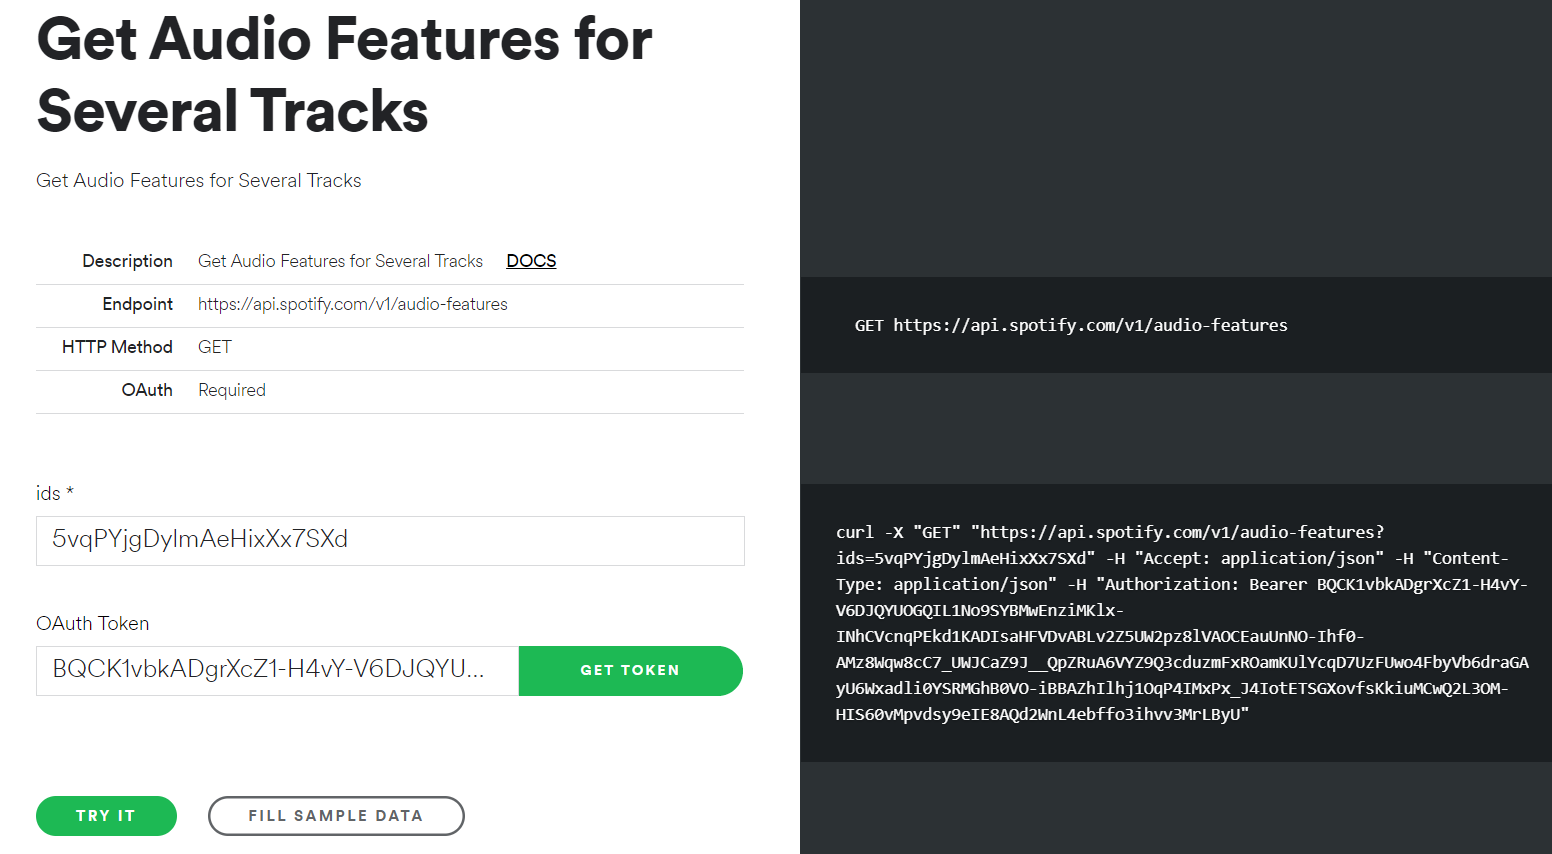

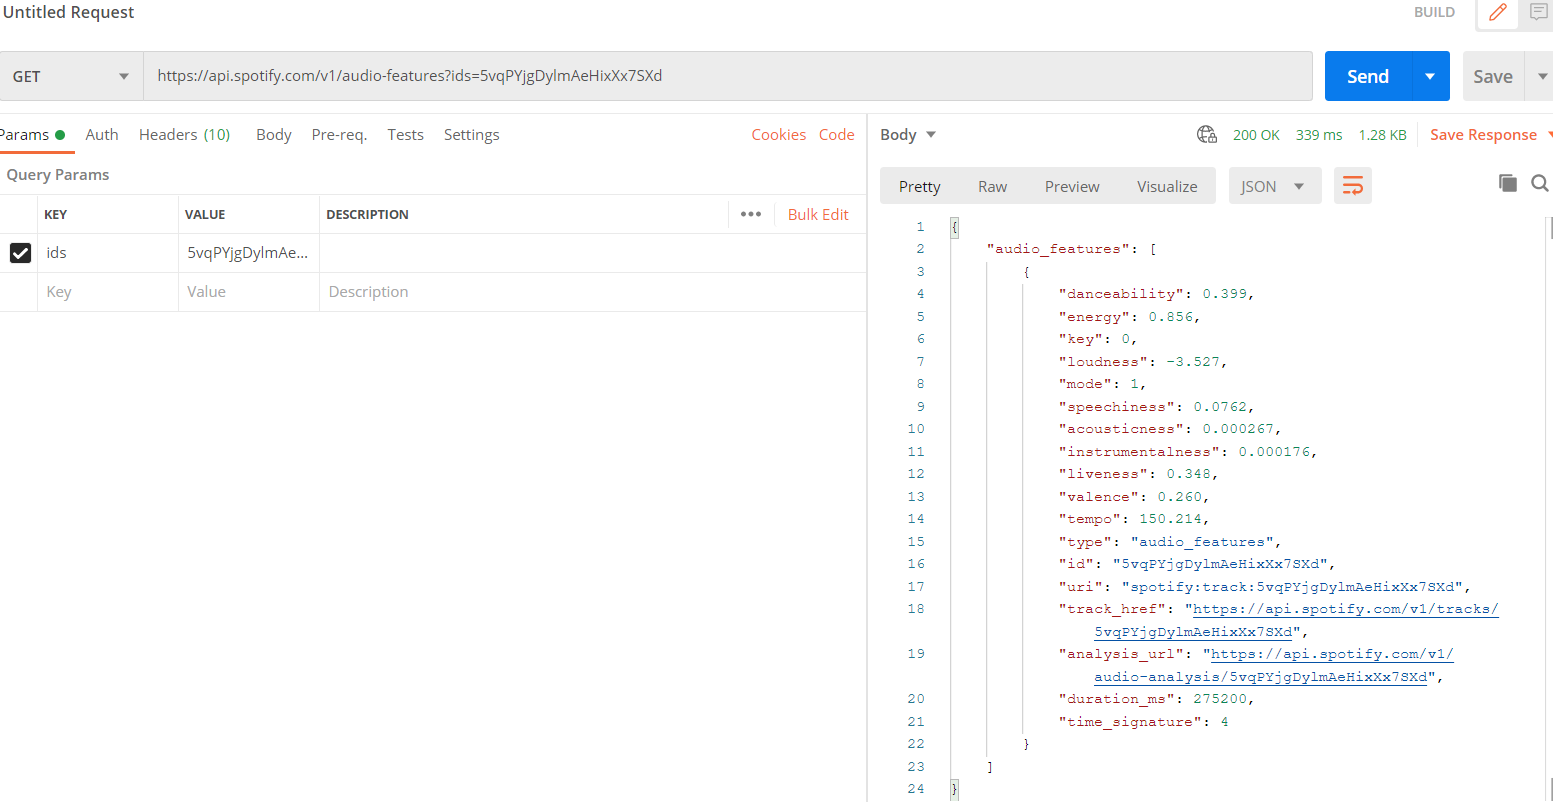

But why these attributes? Do they really distinguish 2 different songs well ? 
> Lets perform a small experiment.

>Comparing values of these feature for 2 very different genre - METAL and CLASSICAL. Google notebook [here](https://colab.research.google.com/drive/1JJUZPdV80NYb29FZ4MuVoNB5vD22zJz5?usp=sharing) performing logistic regression using these audio features.

-breif description of all features is available @ https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

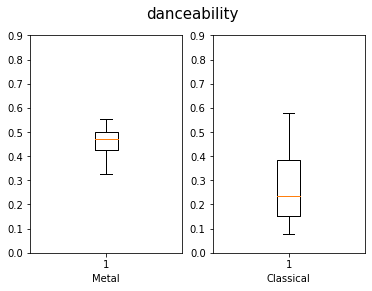

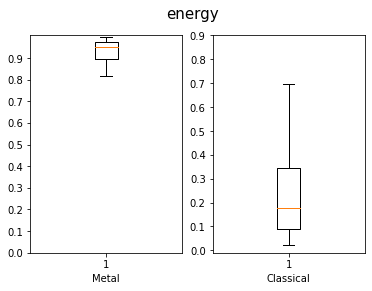

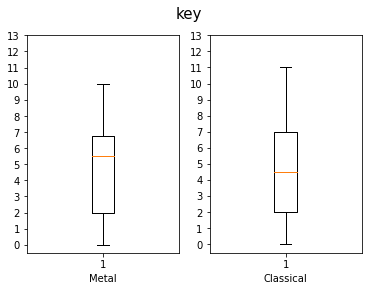

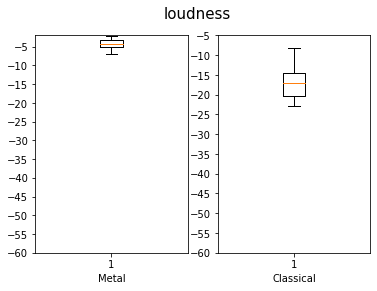

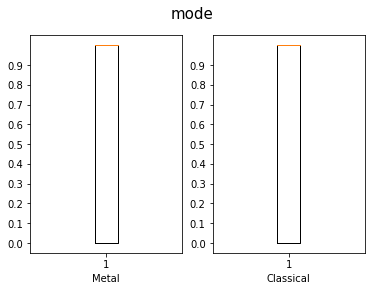

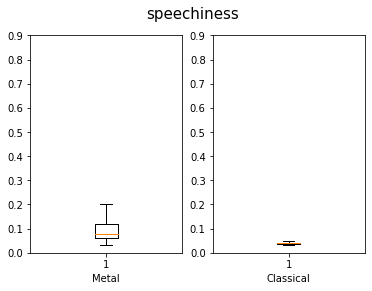

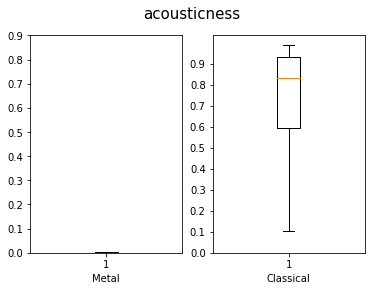

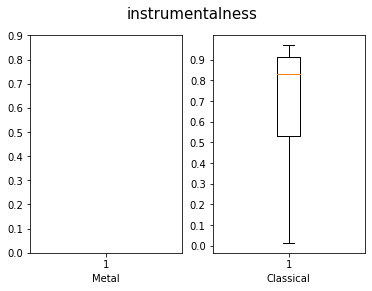

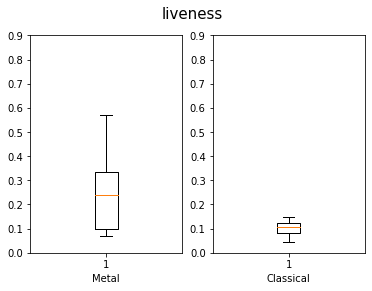

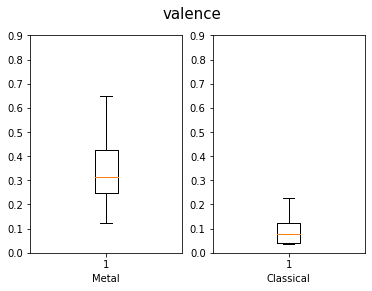

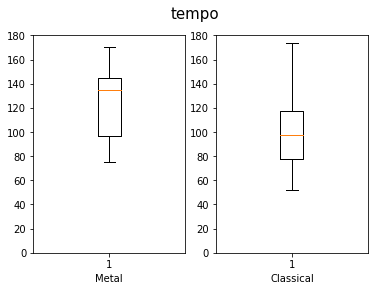

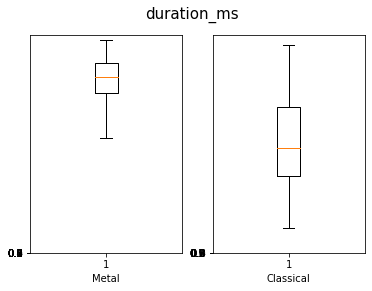

In [ ]:
metal = pd.read_excel('metal.xlsx')
classical = pd.read_excel('classical.xlsx')
metal  = metal.drop(columns = ['type','uri', 'track_href', 'analysis_url', 'id'] )
classical  = classical.drop(columns = ['type','uri', 'track_href', 'analysis_url','id'] )

for i in range( 0 , metal.shape[1]-1):
  fig ,ax = plt.subplots(1,2)
  ax[0].boxplot( metal.iloc[ :, i], showfliers=False)
  ax[1].boxplot(classical.iloc[:,i] , showfliers=False)
  #following step is necessary to ensure y axis has same range to make comparision easier. 
  if i == 2:
    ax[0].set_yticks(np.arange(0, 14 , 1))
    ax[1].set_yticks(np.arange(0, 14 , 1))
  elif i ==3:
    ax[0].set_yticks(np.arange(-60,0, 5))
    ax[1].set_yticks(np.arange(-60,0, 5))
  elif i == 10:
    ax[0].set_yticks(np.arange(0,200, 20))
    ax[1].set_yticks(np.arange(0,200, 20))
  else:  
    ax[0].set_yticks(np.arange(0,1, 0.1))
    ax[1].set_yticks(np.arange(0,1, 0.1))

  ax[0].set_xlabel('Metal')  
  ax[1].set_xlabel('Classical')
  fig.suptitle(metal.columns[i] , fontsize=  15)


## From above it is evident that given features can be good attributes of a song. And, can be considered to differentitate or cluster songs.

Now lets head back to dataset of songs that I like: 

In [ ]:
#Uploadinng dataset into pandas DataFrame
df = pd.read_excel('song features.xlsx')

In [ ]:
#df.dropna(axis = 0 , inplace=True)
df.head()

,Song Name,Song ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,skan give it to them,5vqPYjgDylmAeHixXx7SXd,0.399,0.856,0,-3.527,1,0.0762,0.000267,0.000176,0.348,0.260,150.214,275200
1,Spotlight,6VrCmhRBFnuGKmtNfk4jDs,0.546,0.822,7,-4.483,1,0.0762,0.014500,0.000000,0.742,0.615,150.060,177600
2,Come & Go (ft. Marshmello) – JuiceWRLD,4Lxseh0wN7N0ljiOh8KwbU,0.625,0.811,0,-5.183,1,0.0762,0.017300,0.000000,0.160,0.532,144.994,205485
3,alone marshmeelo,3MEYFivt6bilQ9q9mFWZ4g,0.631,0.953,2,-3.739,1,0.0762,0.024100,0.015500,0.108,0.422,141.990,273803
4,friends mello,08bNPGLD8AhKpnnERrAc6G,0.626,0.880,9,-2.384,0,0.0762,0.205000,0.000000,0.128,0.534,95.079,202621


In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.580492,0.831485,5.530769,-4.121354,0.576923,0.075464,0.057489,0.123639,0.220305,0.374313,133.569523,219893.153846
std,0.111890,0.133939,3.448825,1.713902,0.495959,0.023746,0.113003,0.241851,0.164499,0.188958,25.492637,49526.840376
min,0.204000,0.327000,0.000000,-8.214000,0.000000,0.026100,0.000026,0.000000,0.036000,0.031600,74.873000,109899.000000
25%,0.500000,0.768250,2.000000,-5.307250,0.000000,0.076200,0.002740,0.000000,0.105000,0.243250,125.244750,188773.000000
50%,0.580500,0.857500,5.000000,-4.044500,1.000000,0.076200,0.013600,0.000189,0.147500,0.381000,136.510500,212449.500000
75%,0.661000,0.939000,8.000000,-2.931750,1.000000,0.076200,0.046200,0.069850,0.319750,0.503250,150.047500,247399.000000
max,0.851000,0.993000,11.000000,-0.045000,1.000000,0.252000,0.571000,0.887000,0.767000,0.913000,185.051000,352162.000000


Lets see if our features have any correlation or not

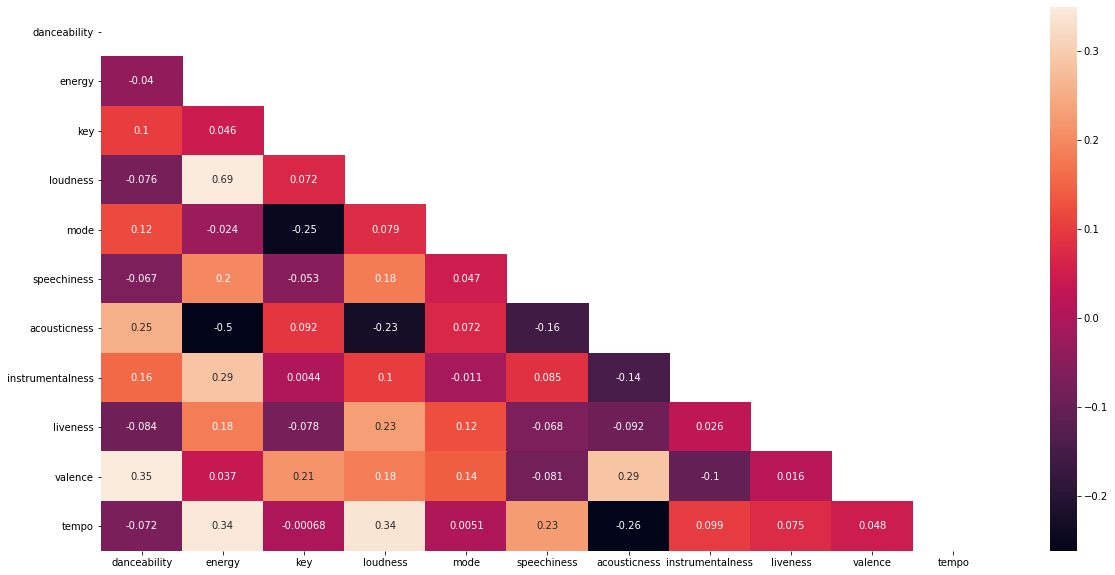

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
#sns.heatmap(df.drop(columns=['Song Name ' , 'Song ID']))
lower_tri = np.triu(df.drop(columns=['Song Name ' , 'Song ID' , 'duration_ms']).corr())
sns.heatmap(df.drop(columns=['Song Name ' , 'Song ID' , 'duration_ms']).corr() , annot=True  , robust = True , mask = lower_tri)

"Loudness" and "Energy" are highly correlated.
>lets plot them !

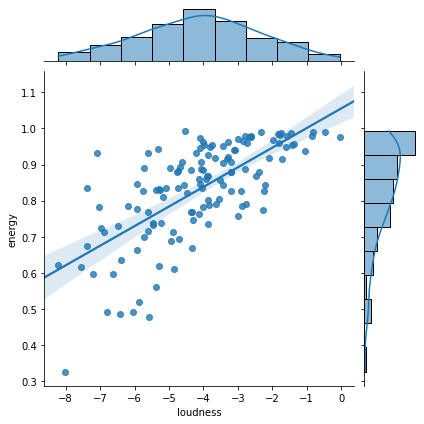

In [ ]:
sns.jointplot(x = df['loudness'] , y = df['energy'], kind="reg", truncate=False)

Even though they have big positive correlation, lets not discard them yet. Because, in prinicipal they capture 2 different and imporatant features of a song  

Lets just remove 'duration_ms' it has very large values and hence will domiante. 

In [ ]:
#removed last feature  'duration_ms' , as it's value is very large compared to other features. 
train  = df.iloc[5: ,2 :-1]
test  = df.iloc[:5  , 2:-1]

In [ ]:
train.shape , test.shape

((125, 11), (5, 11))

#Elbow Method to find optimal K

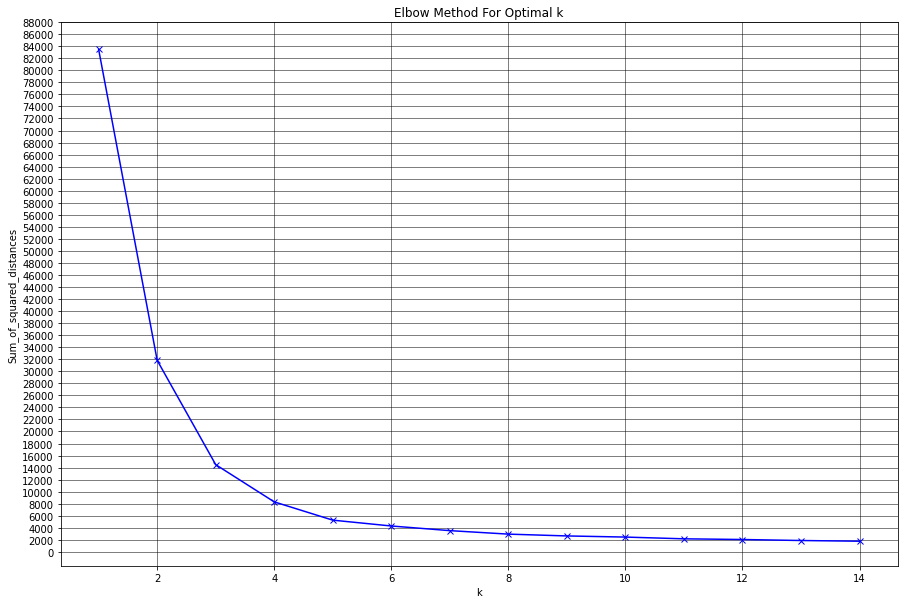

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train)
    Sum_of_squared_distances.append(km.inertia_)

fig , ax = plt.subplots( figsize = (15,10))
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.yticks(np.arange(0,90000,2000))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()   

What is the most optimal K ? 
> Conventionally we would take the elbow point which looks like 4 right? Since graph's y axis has 1 tick =2000 units of error, when elongated the elbow would look more evident at k=6. As we increase k by just 2 from 6 to 8 there is decrese is error of about 1000, but next decrease of 1000 units in error comes after increasing k from 8 to 14. So  k =6,7,8 are almost similar and we will be able to judge better only after looking at individual clusters for all cases i.e k = 6/7/8 To stay on a safer side lets go ahead with k=8 ! 

In [ ]:
df1 = df 
cluster_array = np.concatenate((test_label , train_label))
cluster = pd.Series(cluster_array)
df1['cluster'] = cluster


In [ ]:
df1['cluster'].value_counts()

2    33
6    24
0    22
5    12
4    12
1    11
7     8
3     8
Name: cluster, dtype: int64

In [ ]:
#optimal K is 8
nc = 8

In [ ]:
km = KMeans(n_clusters= nc , random_state= 0 )
km.fit(train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
test_label  = km.predict(test)
test_label

array([0, 0, 6, 6, 5], dtype=int32)

In [ ]:
train_label = km.labels_
train_label

array([5, 7, 6, 6, 2, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 0, 6, 7, 6, 2, 4, 4,
       4, 0, 0, 2, 7, 2, 7, 2, 2, 5, 1, 2, 6, 1, 6, 5, 4, 5, 2, 6, 6, 0,
       3, 0, 0, 0, 5, 7, 0, 7, 0, 2, 2, 6, 1, 2, 3, 6, 6, 2, 4, 0, 0, 4,
       1, 6, 6, 2, 3, 6, 6, 5, 2, 3, 4, 4, 6, 1, 2, 2, 4, 0, 3, 2, 6, 6,
       6, 0, 0, 2, 7, 5, 2, 7, 2, 2, 2, 0, 2, 2, 2, 5, 2, 0, 2, 0, 0, 6,
       0, 0, 5, 4, 1, 1, 5, 4, 4, 6, 3, 5, 6, 3, 1], dtype=int32)

In [ ]:
cluster_centre = pd.DataFrame(km.cluster_centers_).astype('float64')
cluster_centre

,0,1,2,3,4,5,6,7,8,9,10
0,0.572300,0.888500,5.900000,-3.249100,0.650000,0.072135,0.052686,0.105480,0.237425,0.323740,150.383450
1,0.608545,0.784636,6.181818,-4.909727,0.636364,0.070182,0.115608,0.078489,0.204645,0.344909,112.907545
2,0.583364,0.810818,4.393939,-4.452394,0.666667,0.070542,0.042580,0.112576,0.221436,0.339682,128.688939
3,0.513500,0.710375,6.750000,-5.228500,0.500000,0.082937,0.136052,0.140269,0.165975,0.259875,76.782750
4,0.524083,0.889250,6.250000,-3.159500,0.583333,0.102367,0.010872,0.192883,0.254925,0.373425,174.842250
5,0.625818,0.784545,5.181818,-4.850636,0.545455,0.062927,0.097975,0.026075,0.225927,0.493364,96.588909
6,0.596455,0.838955,6.500000,-4.080273,0.363636,0.076900,0.030974,0.182873,0.215027,0.397741,141.464682
7,0.605375,0.896500,5.125000,-3.459625,0.500000,0.076350,0.062971,0.202832,0.155488,0.510250,162.280500


In [ ]:
#function to find distance of new point from nearest k cluster , input x as pandas.
def distance_from_nearest_cluster( k , x ):
  k0 = cluster_centre.iloc[ k , :].to_numpy()
  x  = x.to_numpy()
  sq_diff = np.square( np.subtract(k0 , x))
  distance = np.sqrt( np.sum(sq_diff) )

  return distance



In [ ]:
# small checkpoint to verify the code to find distance for all points in DF.
a = df_for_distancefromcluster.iloc[ 116 , :-1]
k = 0
distance_from_nearest_cluster( k ,a)

5.273449786880077

In [ ]:
#To find distance of all points from nearest cluster 
df_for_distancefromcluster = df1.drop(columns=['Song Name ' , 'Song ID' , 'duration_ms' ])

DISTANCE = []

for i in range(0,df_for_distancefromcluster.shape[0]):
  c = df_for_distancefromcluster.iloc[i , -1]
  dist = distance_from_nearest_cluster(c , df_for_distancefromcluster.iloc[ i , :-1 ])
  DISTANCE.append(dist)

df1['distance from nearest cluster'] = pd.DataFrame(DISTANCE)
df1.head(10)

In [ ]:
# To find distance of farthest point in all k clusters
farthest_distance = []
for i in range(0,8):
  aa = df.loc[df['cluster'] == i]['distance from nearest cluster'].to_numpy()
  farthest_distance.append(np.max(aa))
 

In [ ]:
farthest_distance 

[7.236753896973419,
 8.431011993278135,
 7.593564046475702,
 6.113438955374532,
 12.062732047745687,
 8.561906079023384,
 7.875712191912938,
 6.931287675972127]

Analysing performance of clusters. 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20955 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12390 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38632 missing from current font.
  font.set_

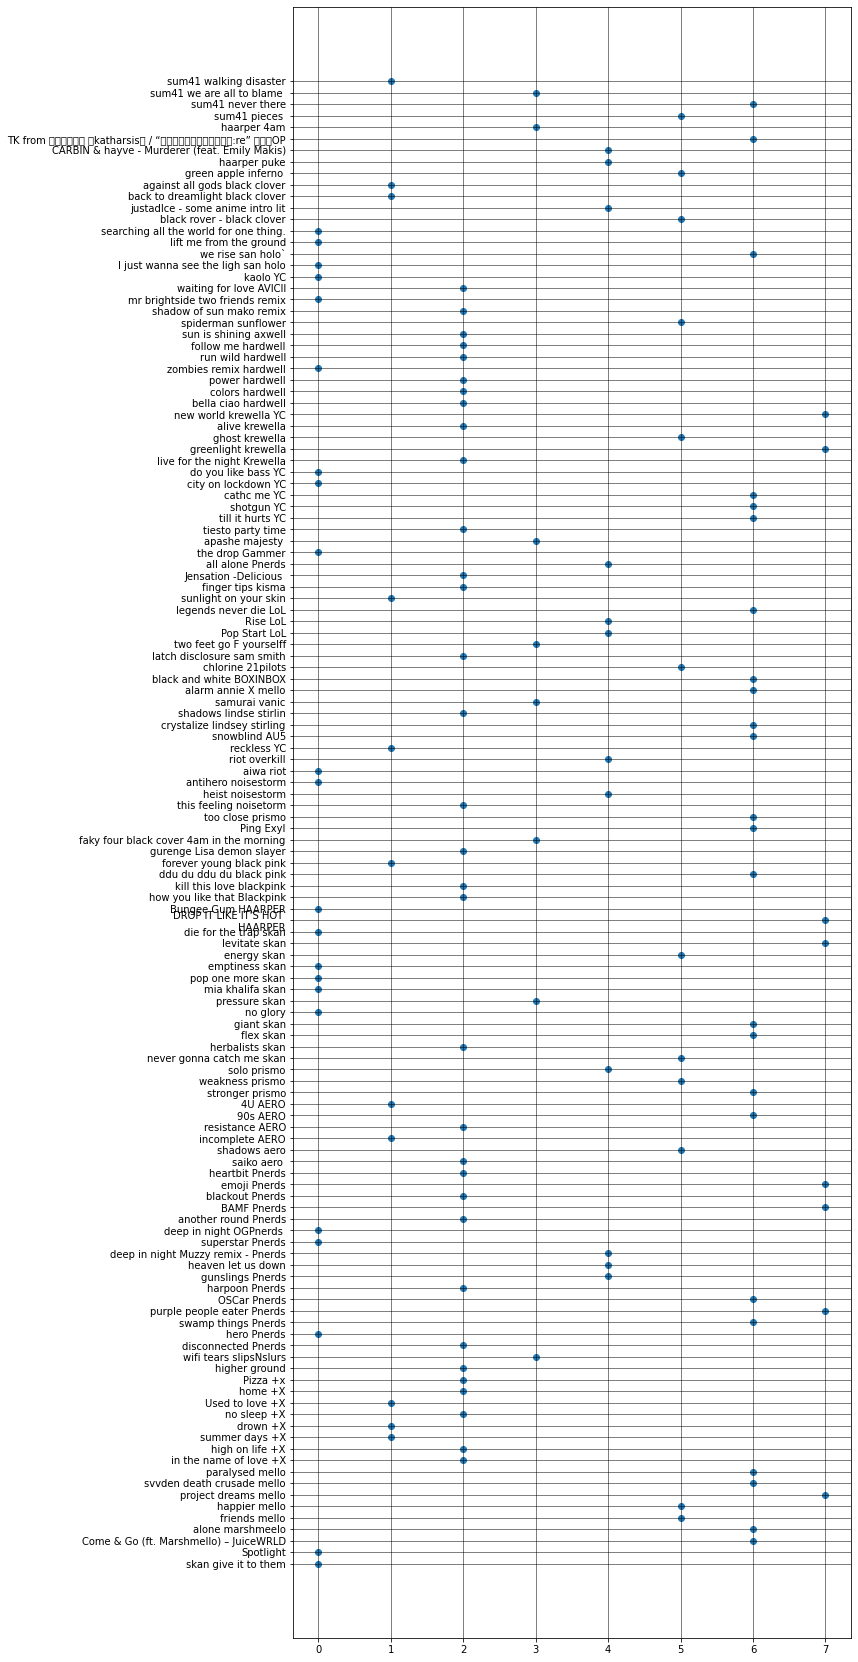

In [ ]:
fig , ax = plt.subplots(figsize = (10,30))
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(0,11))
ax.scatter( df1['cluster'] , df1['Song Name '] )

In [ ]:
df.loc[df['cluster'] == 2 ]

The clusters are performing well above my expecatations! 

  1.Same artists songs are grouped together. 

  2.Furhter if any song of artist is different from other, it is put into another cluster.
  
  3.Two different artists with similar songs are grouped together.  


 

#Testing on a comepletely new data.

In [ ]:
#getting new songs. 
testin = pd.read_excel("new_testing.xlsx")
testin = testin.drop(columns = ['id' , 'duration_ms'])
testin.shape 


(10, 11)

>This activity was carried out before testing data on model.
To make this more intersting, I tried listening to new songs which I had never heard before. And this was my prefere nce - 

[0, 1, 1, 1, 1, 0, 0, 1, 1, 0] 

0  - didn't like

1  - liked

In [ ]:
#predicting whether song should be recommended or not. 
predictions = km.predict(testin)

for i in range(0,testin.shape[0]):
  if distance_from_nearest_cluster(predictions[i] , testin.loc[i]) >= farthest_distance[predictions[i]]:
    print("BAD  recommendation")
  else :
    print("GOOD recommendation")  

BAD  recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
GOOD recommendation
BAD  recommendation


Further tuning is required.Since not recommending a song that I might like is more preferable than recommending songs that I won't like. 